In [1]:
import numpy as np
import re
import itertools
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from random import randint
import matplotlib.pyplot as plt
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [2]:
charToInt = {}
intToChar = {}
def getEncoding(merged_data):
    indx = 0
    fin = []
    for x in merged_data:
        if x not in charToInt:
            charToInt[x] = indx
            intToChar[indx] = x
            indx += 1
        fin.append(charToInt[x])
    return fin
            
def loadMusic(file):
    f = open(file, 'r')
    text = f.read()
    text = text.replace("\r", "")
    words = re.split(r"(\s+)", text)
    new_words = words #[x for x in words if (x != '<start>' and x != '<end>')] # get rid of <start> and <end>
    data = []
    [data.append(list(w)) for w in new_words]
    merged_data = np.asarray(list(itertools.chain.from_iterable(data)))  
#    s = set(merged_data)
#    char_int = [ch:i for i,ch in enumerate(s)] # encode characters to integers
#    int_char = [i:ch for i,ch in enumerate(s)] # encode integers to characters
    encoded_data = getEncoding(merged_data)#[ord(x) for x in merged_data] # assing ascii labels to characters
    return encoded_data

def prepareData(data, t):
	dataX, dataY = [], []
	for i in range(len(data) - t - 1):
		a = data[i:(i+t)]
		dataX.append(a)
		dataY.append(data[i + t])
	return np.array(dataX), np.array(dataY)

def splitData(data, v):
    train_size = int(len(data[0]) * v) # v is between 0 and 1
    train, test = (data[0][0:train_size],data[1][0:train_size]), (data[0][train_size:len(data[0])],data[1][train_size:len(data[0])])
    return train, test

def sliceData(data, s):
    dataX, dataY = data[0], data[1]
    X, Y = [], []
    windowStride = 5
    for i in range((len(data[0])-s - 1) / windowStride):
        seq = i * windowStride #randint(1,len(data[0])-20)
        sliceX = dataX[seq:seq+s]
        sliceY = dataY[seq+s-1]
        X.append(sliceX)
        Y.append(sliceY)
    data = (X, Y)
    return splitData(data, 0.8)

In [4]:
file = 'input.txt'
abc_list = loadMusic(file) # read in data
lvl = np.min(abc_list)
abc_list = abc_list - lvl
vocab = np.max(abc_list)
print lvl


data = prepareData(abc_list, 1) # prepare inputs and targets
#dataslice = sliceData(data, s = 2) # slice into sequences of length s

train_seq, test_seq = sliceData(data, 30)
y_train = train_seq[1]
y_test = test_seq[1]

print len(y_train), len(train_seq[0])

# one-hot encoding targets
X_train = np_utils.to_categorical(train_seq[0], vocab+1)
X_test = np_utils.to_categorical(test_seq[0], vocab+1)
Y_train = np_utils.to_categorical(train_seq[1], vocab+1)
Y_test = np_utils.to_categorical(test_seq[1], vocab+1)
print X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

seq = 30; # sequence length
X_train = X_train[0:int(X_train.shape[0]/seq)*seq][:]
Y_train = Y_train[0:int(Y_train.shape[0])][:]
X_test = X_test[0:int(X_test.shape[0]/seq)*seq][:]
Y_test = Y_test[0:int(Y_test.shape[0])][:]
print X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

X_train = X_train.reshape(int(X_train.shape[0]/seq), seq, X_train.shape[1]) # reshape input for RNN
X_test = X_test.reshape(int(X_test.shape[0]/seq), seq, X_test.shape[1])
Y_train = Y_train.reshape(int(Y_train.shape[0]), Y_train.shape[1]) # reshape input for RNN
Y_test = Y_test.reshape(int(Y_test.shape[0]), Y_test.shape[1])


0
80229 80229
(2406870, 93) (80229, 93) (601740, 93) (20058, 93)
(2406870, 93) (80229, 93) (601740, 93) (20058, 93)


In [114]:
from keras import backend as K

T = 1
def softmax(x):
    return K.softmax(x/T)

In [148]:
hid_neurons = 100
nb_classes = np.shape(Y_train)[-1]


#%% create model
model = Sequential()
model.add(SimpleRNN(output_dim = hid_neurons,
                    init='glorot_uniform', inner_init='orthogonal', activation='relu',
                    W_regularizer=None, U_regularizer=None, b_regularizer=None,
                    dropout_W=0.0, dropout_U=0.0, return_sequences = False,
                    input_shape = X_train.shape[1:]))
# model.add(Dropout(0.3))
model.add(Dense(output_dim = nb_classes))
model.add(Activation(softmax))
# model.summary()

adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)


model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])

#%% train model and save weights
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [149]:
history = model.fit(X_train, Y_train, nb_epoch = 25, shuffle = True, validation_data = (X_test, Y_test))

Train on 80229 samples, validate on 20058 samples
Epoch 1/25
80229/80229 [==============================] - 27s - loss: 13.8882 - acc: 0.1373 - val_loss: 14.1003 - val_acc: 0.1252
Epoch 2/25
80229/80229 [==============================] - 27s - loss: 13.9036 - acc: 0.1374 - val_loss: 14.1003 - val_acc: 0.1252
Epoch 3/25
80229/80229 [==============================] - 27s - loss: 13.9036 - acc: 0.1374 - val_loss: 14.1003 - val_acc: 0.1252
Epoch 4/25
80229/80229 [==============================] - 27s - loss: 13.9036 - acc: 0.1374 - val_loss: 14.1003 - val_acc: 0.1252
Epoch 5/25
80229/80229 [==============================] - 26s - loss: 13.9036 - acc: 0.1374 - val_loss: 14.1003 - val_acc: 0.1252
Epoch 6/25
80229/80229 [==============================] - 27s - loss: 13.9036 - acc: 0.1374 - val_loss: 14.1003 - val_acc: 0.1252
Epoch 7/25
80229/80229 [==============================] - 27s - loss: 13.9036 - acc: 0.1374 - val_loss: 14.1003 - val_acc: 0.1252
Epoch 8/25
80229/80229 [================

In [150]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss, T = 1, H = 100, adagrad')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
# plt.show()
plt.savefig('Loss, T = 1, H = 100, adagrad')
plt.gcf().clear()

In [151]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy with h = 100, T = 1, adagrad')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# fig = plt.show()
# plt.show()
plt.savefig('Acc, T = 1, H = 100, adagrad')
plt.gcf().clear()

In [99]:
from keras import backend as K
val = K.function([model.layers[0].input], [(model.layers[0].output)])

In [ ]:
inp = X_train[0, :, :]
inp.shape
import sys

arr = []
for i in range(1000):
    out = model.predict(np.reshape(inp, (1, 30, 93)))
    final = np.random.choice(np.arange(0, 93), p = out[0])
    sys.stdout.write(intToChar[final])
#     arr.append(val([np.reshape(inp, (1, 30, 93))])[0][0][3])
    nextInp = np_utils.to_categorical(final, nb_classes=93)
    inp = np.ma.row_stack((inp, nextInp))
    inp = inp[1:]

In [76]:
np.array(arr).shape

(0,)

In [413]:
from keras import backend as K
val = K.function([model.layers[0].input], [(model.layers[0].output)])

# Data is in music
data = []
for i in range(len(music)-30):
    x = []
    for j in range(i, i+30):
        temp = 93*[0]
        temp[charToInt[music[j]]] = 1
        x.append(temp)
    data.append(x)

ndata = np.array(data[:200])

inp = ndata[0, :, :]
import sys

arr = []
for i in range(200):
    inp = ndata[i]
    arr.append(val([np.reshape(inp, (1, 30, 93))])[0][0][10])

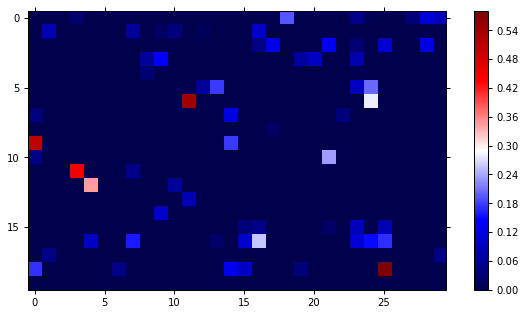

In [29]:
from matplotlib import cm as CM

plt.figure(figsize=(10, 5)
plt.imshow(np.reshape(arr, (20, 30)), cmap = 'RdBu')
plt.colorbar()
plt.show()